In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import numpy as np

In [3]:
batch_size = 64

# Adding random rotation to the data augmentation process
transform = transforms.Compose([
    transforms.RandomRotation(degrees=180),  # Rotate the image by up to 180 degrees
    transforms.Resize(224),  # Scale up to fit VGG's input size requirement, adjust if necessary
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing the images
])

# Data loaders for MNIST dataset
trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38956947.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1096181.18it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9539936.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5352775.71it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
# Define the VGG-like model
# Define the vgg_block function
def vgg_block(num_convs, in_channels, num_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=num_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = num_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_arch = ((1, 1, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512), (2, 512, 512))
        layers = []
        for (num_convs, in_channels, num_channels) in self.conv_arch:
            layers += [vgg_block(num_convs, in_channels, num_channels)]
        self.features = nn.Sequential(*layers)
        self.dense1 = nn.Linear(512 * 7 * 7, 4096)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.dense3(self.drop2(F.relu(self.dense2(self.drop1(F.relu(self.dense1(x)))))))
        return x

In [5]:
# Function to evaluate accuracy
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval()  # Set the model to evaluation mode
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train()  # Set the model back to training mode
            n += y.shape[0]
    return acc_sum / n

# Train function
def train(train_iter, test_iter, net, optimizer, device, num_epochs):
    net = net.to(device)
    print("Training on", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in tqdm(train_iter):
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
        print(f'Epoch {epoch + 1}, Loss {train_l_sum}')


In [6]:
import matplotlib.pyplot as plt

def train_and_validate(train_iter, test_iter, net, optimizer, device, num_epochs):
    net = net.to(device)
    print("Training on", device)
    loss = torch.nn.CrossEntropyLoss()
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in tqdm(train_iter):
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]

        train_accuracy = train_acc_sum / n
        training_accuracies.append(train_accuracy)

        validation_accuracy = evaluate_accuracy(test_iter, net, device)
        validation_accuracies.append(validation_accuracy)

        print(f'Epoch {epoch + 1}, Loss {train_l_sum / n:.4f}, '
              f'Train Accuracy {train_accuracy:.4f}, '
              f'Validation Accuracy {validation_accuracy:.4f}')

    return training_accuracies, validation_accuracies

In [11]:
# Prepare the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network and optimizer
net = Net()
optimizer = optim.Adam(net.parameters())

# Number of epochs
num_epochs = 2

# Train the model and capture accuracies
training_accuracies, validation_accuracies = train_and_validate(trainloader, testloader, net, optimizer, device, num_epochs)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Training on cuda


  0%|          | 0/938 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [256, 128, 3, 3], expected input[64, 256, 56, 56] to have 128 channels, but got 256 channels instead

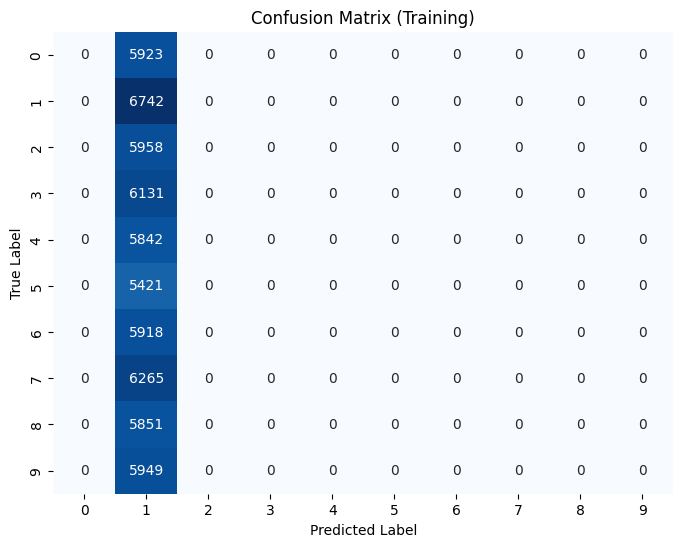

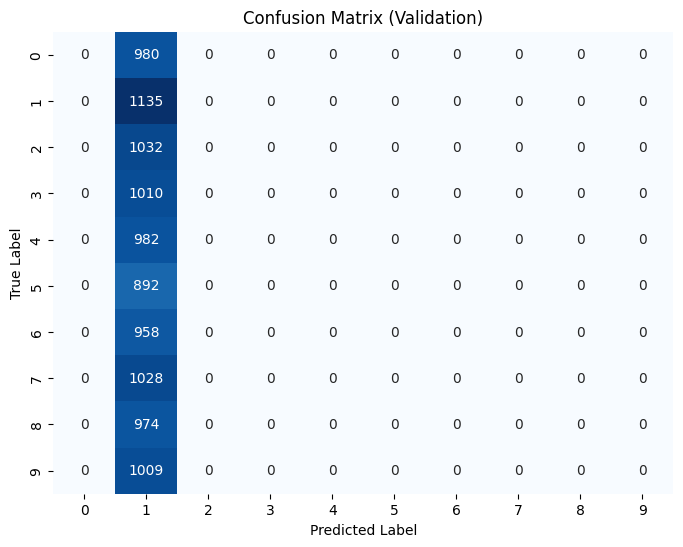

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
confusion_train = confusion_matrix(true_labels_train, pred_labels_train)
confusion_val = confusion_matrix(true_labels_val, pred_labels_val)

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Training)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

